In [1]:
lookback = 10
avg_offset = 10 # takes mean over signals avg_window in the past to avg_window in the future
avg_window_0d=10
avg_window_1d=10
avg_window=10
delay = 1

In [2]:
import numpy as np
import pickle
import copy

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
titlesize=20
othersize=20

In [5]:
dirname='/global/homes/a/abbatej/'
with open(dirname+'final_data.pkl', 'rb') as f: 
    raw_data=pickle.load(f, encoding='latin1')

In [6]:
num_train_shots=700
num_val_shots=200

In [42]:
shots = sorted(raw_data.keys())

In [43]:
raw_data[160947].keys()

dict_keys(['elongation_up', 'curr', 'i_temp', 'e_temp', 'pinj', 'triangularity_up', 'curr_target', 'drsep', 'elongation_low', 'e_dens', 'Z0', 'tinj', 'i_dens', 'R0', 'zeta_in_up', 'epsilon', 'zeta_out_up', 'press', 'rotation', 'triangularity_low', 'zeta_in_low', 'gasA', 'gasB', 'q', 'time', 'R_geo', 'zeta_out_low'])

In [7]:
# specify the signals we want
sigs_1d = sorted(['e_temp','e_dens'])
sigs_0d = sorted(['curr_target','tinj', 'pinj'])#, 'gasA'])
sigs = sigs_0d+sigs_1d

In [8]:
# average over the previous avg_window timesteps 
def smooth_signal(sig, avg_window):
    #do nothing:
    #return np.array(sig)
    
    #actually smooth:
    return np.array([np.mean(sig[ind-avg_window:ind],axis=0) for ind in range(avg_offset, len(sig))])

    # for getting the full mean over rho points
    #return np.array([np.mean(sig[ind-avg_window:ind]) for ind in range(avg_offset, len(sig))])


In [46]:
plt.rcParams['figure.figsize'] = [15, 10]
font={'size': 15, 'weight':'heavy'}
plt.rc('font', **font)

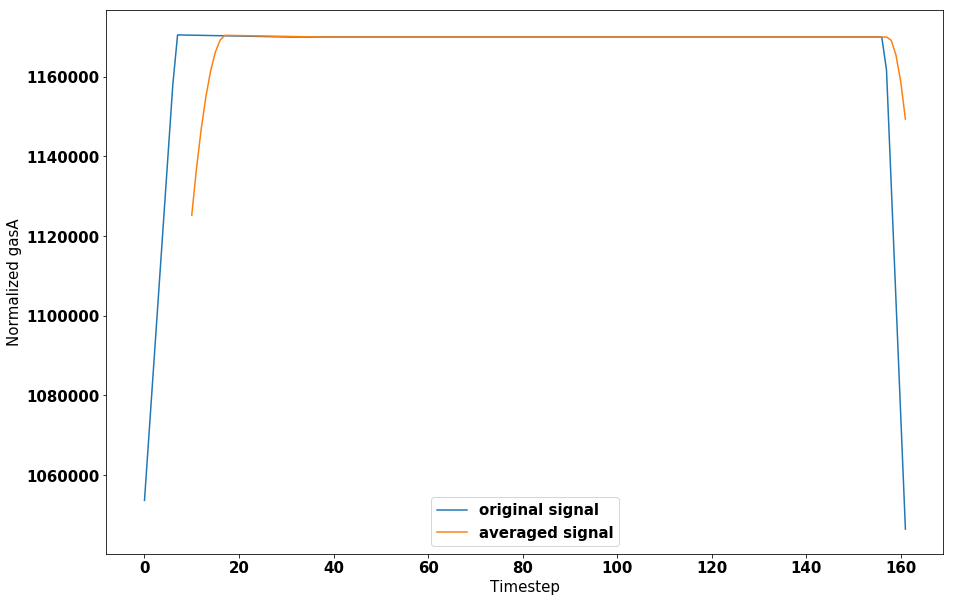

In [47]:
sig=np.mean(raw_data[161110]['e_temp'],axis=1)
sig=raw_data[161110]['curr_target']

new_data=smooth_signal(sig, avg_window_1d)
plt.plot(sig, label='original signal')
plt.plot(list(range(avg_offset,len(sig))),new_data,label='averaged signal')
plt.xlabel('Timestep')
plt.ylabel('Normalized gasA')
plt.legend()
plt.show()

Shot 163531


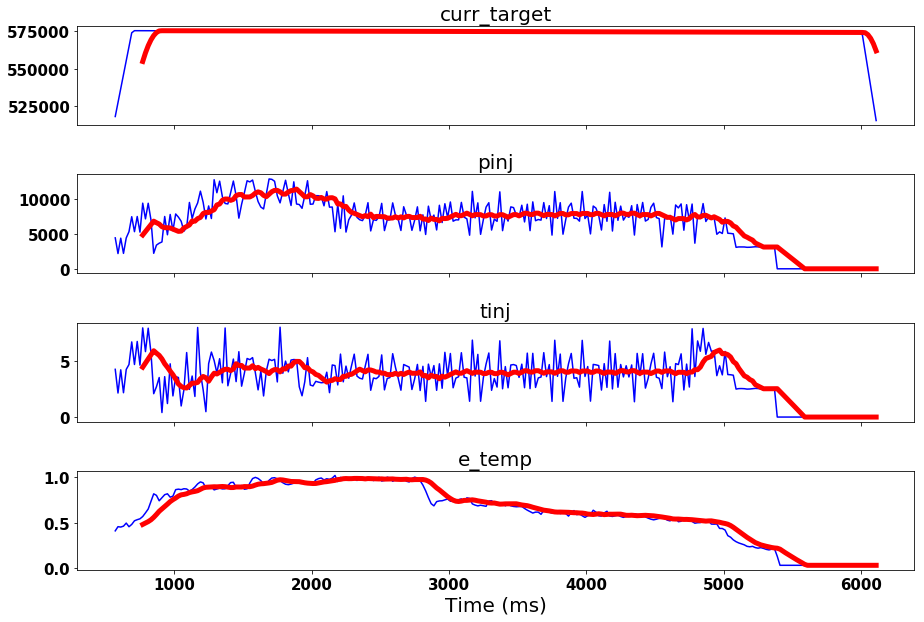

In [48]:
#sigs=['e_temp','e_dens','pinj','curr','gasA','tinj']
test_sigs_1d=['e_temp','i_temp','e_dens','i_dens','rotation']
shot=163531 #shots[np.random.randint(len(shots))]
print('Shot {}'.format(shot))
fig,axarr = plt.subplots(len(sigs),1,sharex=True)
for i in range(len(sigs)):
    sig=raw_data[shot][sigs[i]]
    if sigs[i] in test_sigs_1d:
        sig=np.mean(sig,axis=1)
    axarr[i].plot(raw_data[shot]['time'], 
                  sig,label=sigs[i],c='b')
    smooth_sig=smooth_signal(sig, avg_offset)
    axarr[i].plot(raw_data[shot]['time'][list(range(avg_offset,len(sig)))], smooth_sig,
                  c='r',linewidth=5)
    axarr[i].set_title(sigs[i], fontsize=othersize)
axarr[-1].set_xlabel('Time (ms)',fontsize=othersize)
plt.subplots_adjust(hspace=.5)
plt.show()

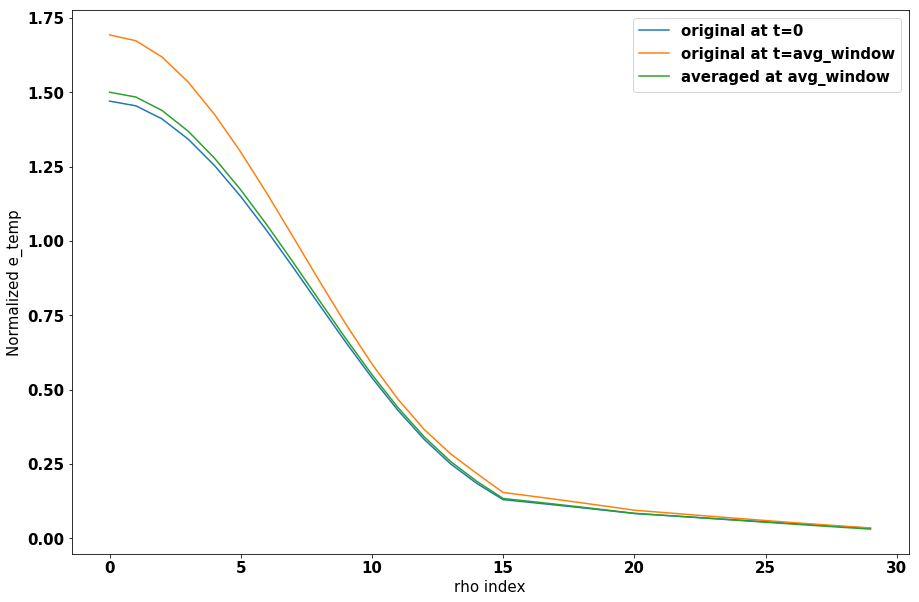

In [49]:
sig=raw_data[shots[0]]['e_temp']

new_data=smooth_signal(sig, avg_window)
plt.plot(sig[0], label='original at t=0')
plt.plot(sig[avg_window_1d], label='original at t=avg_window')
plt.plot(new_data[0],label='averaged at avg_window')
plt.xlabel('rho index')
plt.ylabel('Normalized e_temp')
plt.legend()
plt.show()

In [77]:
# first get the indices that contain all the data we need
# (both train and validation)
train_shots=[]
val_shots=[]
for shot in shots:
    if set(sigs).issubset(raw_data[shot].keys()):
        if (len(train_shots)<num_train_shots):
            train_shots.append(shot)
        elif (len(val_shots)<num_val_shots):
            val_shots.append(shot)
        else:
            break

In [78]:
# smooth each signal
data={}
for shot in (train_shots+val_shots):
    data[shot]={}
    for sig in sigs_0d:
        data[shot][sig] = smooth_signal(raw_data[shot][sig],avg_window_0d)
    for sig in sigs_1d:
        data[shot][sig] = smooth_signal(raw_data[shot][sig],avg_window_1d)

In [79]:
count=0
for shot in (train_shots+val_shots):
    if data[shot]['e_temp'].size==0:
        count+=1
        data.pop(shot,None)
        if shot in train_shots:
            train_shots.remove(shot)
        if shot in val_shots:
            val_shots.remove(shot)
print('Removed {} shots with empty arrays'.format(count))

Removed 15 shots with empty arrays


In [62]:
#### EXCLUDE FLATTOP ######

for shot in (train_shots+val_shots):
    for sig in (sigs_0d+sigs_1d):
        data[shot][sig] = data[shot][sig][:20]

###########################

In [80]:
means={}
stds={}

for sig in sigs:
    means[sig] = np.nanmean(np.array([np.nanmean(data[shot][sig], axis=0) for shot in train_shots]),axis=0)
    stds[sig] = np.nanstd(np.array([np.nanmean(data[shot][sig],axis=0) for shot in train_shots]),axis=0)

In [81]:
print(means)
print(stds)

{'curr_target': 1059772.3698266281, 'pinj': 4396.059190843108, 'tinj': 3.0656344063782472, 'e_temp': array([2.71518538, 2.69066433, 2.62113573, 2.51291218, 2.37266662,
       2.20737097, 2.02422403, 1.83055422, 1.63362937, 1.44055191,
       1.25770287, 1.0903946 , 0.94207629, 0.81316672, 0.69819478,
       0.55193655, 0.51224344, 0.46370186, 0.40394037, 0.33255335,
       0.25504226, 0.21316824, 0.17442696, 0.14023821, 0.1113577 ,
       0.08794352, 0.06947777, 0.05518859, 0.04416454, 0.03565152])}
{'curr_target': 204211.8497935658, 'pinj': 2150.522843653218, 'tinj': 1.8072916361387679, 'e_temp': array([0.79159928, 0.78493968, 0.76629277, 0.73801857, 0.70275617,
       0.66322502, 0.62199353, 0.58121844, 0.54238781, 0.50600766,
       0.47192874, 0.43975736, 0.40959639, 0.38217389, 0.35512491,
       0.29999599, 0.28219378, 0.25927657, 0.22839506, 0.18898422,
       0.14525317, 0.12090994, 0.09765007, 0.07652428, 0.05854136,
       0.04428921, 0.03370142, 0.02624023, 0.02109471, 0.017

In [55]:
def normalize(obj, mean, std):
    return (obj-mean)/std

def make_final_data(my_shots):
    final_data=[]
    final_target=[]
    for shot in my_shots:
        num_timesteps=len(data[shot][sigs[0]])
        
        for end_time in range(lookback, num_timesteps-delay):
            final_data.append([])
            final_target.append([])
            
            for sig in sigs_1d:
                # for MEAN:
                #final_target[-1].append(np.mean(normalize(data[shot][sig][end_time+delay], means[sig], stds[sig])))

                # for predicting DIFFERENCES
                final_target[-1].extend(normalize(data[shot][sig][end_time+delay], means[sig], stds[sig])-
                                       normalize(data[shot][sig][end_time], means[sig], stds[sig]))

                # for predicting MEAN, DIFFERENCES
                #final_target[-1].append(np.mean(normalize(data[shot][sig][end_time+delay], means[sig], stds[sig])-
                #                       normalize(data[shot][sig][end_time], means[sig], stds[sig])))
                
                # regular:
                #final_target[-1].extend(normalize(data[shot][sig][end_time+delay], means[sig], stds[sig]))
                
            for time in range(end_time-lookback,end_time):
                final_data[-1].append([])
                for sig in sigs_0d:
                    # used to be time+delay below because the 0d signals are actuators
                    new_sig = normalize(data[shot][sig][time], means[sig], stds[sig])
                    final_data[-1][-1].append(new_sig)
                for sig in sigs_1d:
                    new_sig = normalize(data[shot][sig][time], means[sig], stds[sig])
                    
                    # for just MEAN:
                    #final_data[-1][-1].append(np.mean(new_sig))
                    
                    # regular:
                    final_data[-1][-1].extend(new_sig)
    return (np.array(final_data), np.array(final_target))

train_tuple = make_final_data(train_shots)
train_data = train_tuple[0]
train_target = train_tuple[1]

val_tuple = make_final_data(val_shots)
val_data = val_tuple[0]
val_target = val_tuple[1]

Index 77000



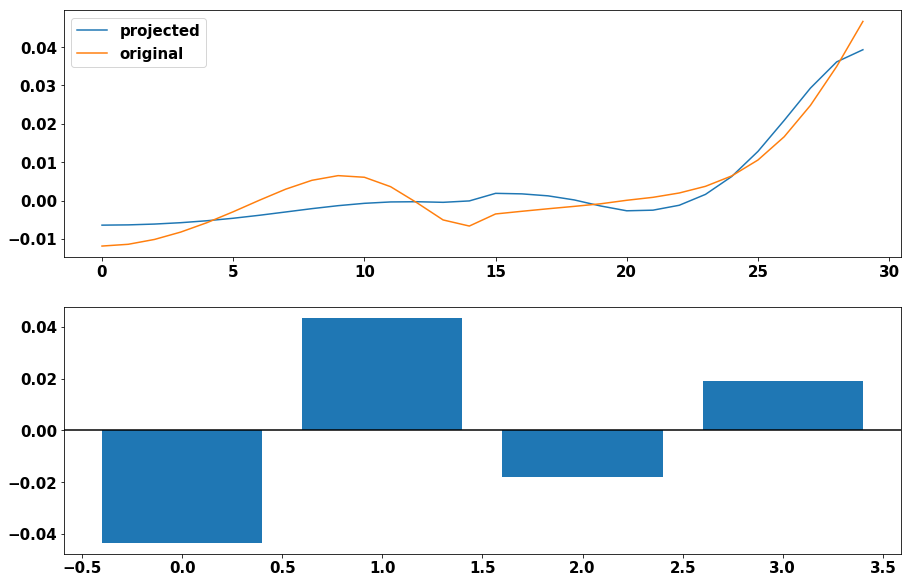

In [73]:
####### PROJECT WITH PCA ########

from sklearn import decomposition

pre_pca_data=train_target
pca=decomposition.PCA(n_components=4)
pca.fit(pre_pca_data)
pca_data=pca.transform(pre_pca_data)

# To plot the individual PCA components
'''
plt.rcParams['figure.figsize'] = [10, 20]
font={'size': 15, 'weight':'heavy'}
plt.rc('font', **font)
fig=plt.figure()
num_plots=min(9,len(pca.components_))
for i in range(num_plots):
    ax=fig.add_subplot('{}{}{}'.format(num_plots,1,i+1))
    ax.plot(pca.components_[i])
    ax.set_title('PCA Component {}'.format(i))
    ax.set_xlabel('rho')
plt.xlabel('rho',fontsize=20)
plt.subplots_adjust(hspace=1)
plt.show()
'''

# To plot an example comparing true to projected

fig=plt.figure()
ind=np.random.choice(len(pca_data))
ax=fig.add_subplot('211')
ax.plot(pca.inverse_transform(pca_data[ind]),label='projected')
ax.plot(pre_pca_data[ind],label='original')
ax.legend()

ax=fig.add_subplot('212')
ax.bar([i for i  in range(len(pca_data[ind]))],pca_data[ind])
ax.axhline(0,color='k')
print('Index {}\n'.format(ind))
plt.show()


#################################

In [74]:
##### TRANSFORM DATA WITH PCA #####

train_data_pca = np.zeros((train_data.shape[0],train_data.shape[1],len(sigs_0d)+pca.n_components_))
train_data_pca[:,:,:len(sigs_0d)]=train_data[:,:,:len(sigs_0d)]
for t in range(train_data.shape[1]):
    train_data_pca[:,t,len(sigs_0d):] = pca.transform(train_data[:,t,len(sigs_0d):])

val_data_pca = np.zeros((val_data.shape[0],val_data.shape[1],len(sigs_0d)+pca.n_components_))
val_data_pca[:,:,:len(sigs_0d)]=val_data[:,:,:len(sigs_0d)]
for t in range(val_data.shape[1]):
    val_data_pca[:,t,len(sigs_0d):] = pca.transform(val_data[:,t,len(sigs_0d):])
    
#########################################

In [21]:
# note the shape reflects (num_samples, lookback, num_features)
# num_features has 22 rho values for each 1d sig and 1 value for each 0d sig
print(np.array(raw_data[shots[0]]['pinj']).shape)
print(train_data.shape)

(265,)
(132090, 10, 33)


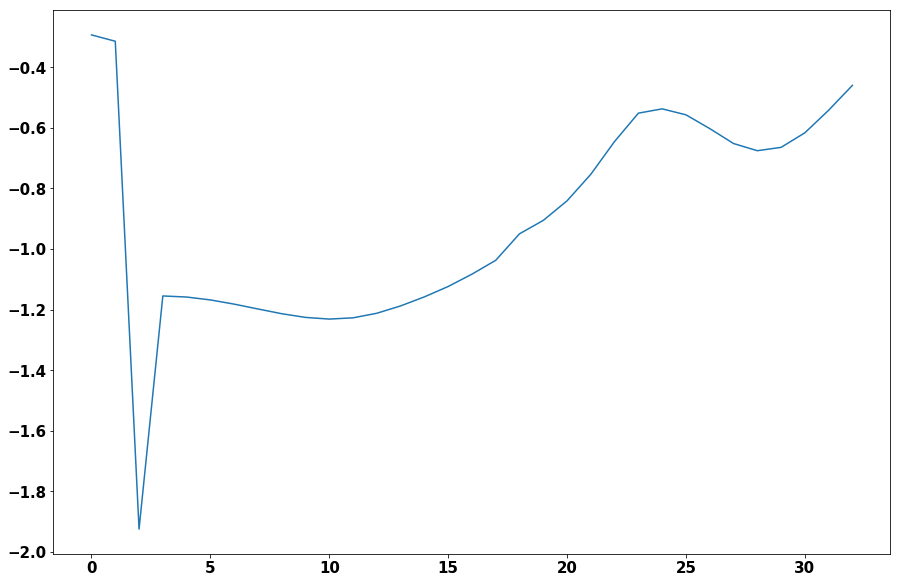

In [22]:
#plt.plot(raw_data[shots[0]]['pinj'])
plt.plot(train_data[0,-1])

In [75]:
with open(dirname+'train_data.pkl', 'wb') as f: 
    #FOR PCA:
    pickle.dump(train_data_pca, f)
    
    #For regular:
    #pickle.dump(train_data, f)

In [61]:
with open(dirname+'train_target.pkl', 'wb') as f: 
    pickle.dump(train_target, f)

In [76]:
with open(dirname+'val_data.pkl', 'wb') as f: 
    #FOR PCA:
    pickle.dump(val_data_pca, f)
    
    #For regular:
    #pickle.dump(val_data, f)

In [63]:
with open(dirname+'val_target.pkl', 'wb') as f: 
    pickle.dump(val_target, f)

In [64]:
with open(dirname+'means.pkl', 'wb') as f: 
    pickle.dump(means, f)

In [65]:
with open(dirname+'stds.pkl', 'wb') as f: 
    pickle.dump(stds, f)

In [66]:
#train_indices=np.cumsum([len(raw_data[shot]['e_temp'])-avg_offset-delay-lookback for shot in train_shots])
train_indices=np.cumsum([len(data[shot]['e_temp'])-avg_offset-delay-lookback for shot in train_shots])
train_indices=np.insert(train_indices,0,0)
#val_indices=np.cumsum([len(raw_data[shot]['e_temp'])-avg_offset-delay-lookback for shot in val_shots])
val_indices=np.cumsum([len(data[shot]['e_temp'])-avg_offset-delay-lookback for shot in val_shots])
val_indices=np.insert(val_indices,0,0)

In [67]:
def get_time_values(my_shots):
    times=[]
    for shot in my_shots:
        num_timesteps=len(data[shot][sigs[0]])
        for time in range(lookback, num_timesteps-delay):
            # used to be time+delay below because the 0d signals are actuators
            time = raw_data[shot]['time'][time]
            times.append(time)
    return times

val_time_values=get_time_values(val_shots)
train_time_values=get_time_values(train_shots)

In [68]:
with open(dirname+'train_time.pkl', 'wb') as f: 
    pickle.dump(train_time_values, f)

In [69]:
with open(dirname+'val_time.pkl', 'wb') as f: 
    pickle.dump(val_time_values, f)

In [70]:
shot_indices={'train_shot_indices': train_indices,
             'val_shot_indices': val_indices,
             'train_shot_names': train_shots,
             'val_shot_names': val_shots}

In [71]:
with open(dirname+'shot_indices.pkl', 'wb') as f: 
    pickle.dump(shot_indices, f)

In [72]:
len(val_indices)

200